# Create ACS Index and Azure SQL Database for Avatar Demo
Use this notebook to create an Azure Cognitive Search Index and an Azure SQL Database and populate demo content for the Avatar outdoor shop application.  

Ensure that you have the the Microsoft ODBC driver for SQL Server installed. Here are the instructions for Linux based systems:  
https://learn.microsoft.com/en-us/sql/connect/odbc/linux-mac/installing-the-microsoft-odbc-driver-for-sql-server?view=sql-server-ver16&tabs=ubuntu18-install%2Calpine17-install%2Cdebian8-install%2Credhat7-13-install%2Crhel7-offline#18


## Setup

In [1]:
# Install the required libraries
%pip install azure-search-documents==11.4.0b6 openai==0.28.1 tenacity pyodbc

# Install library for Azure Authentication
%pip install azure-identity azure-storage-blob

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import json  
import pandas as pd

import pyodbc
import requests
import inspect

import openai  
from tenacity import retry, wait_random_exponential, stop_after_attempt  
from azure.core.credentials import AzureKeyCredential  
from azure.search.documents import SearchClient  
from azure.search.documents.indexes import SearchIndexClient  
from azure.search.documents.models import Vector  
from azure.search.documents.indexes.models import (  
    SearchIndex,  
    SearchField,  
    SearchFieldDataType,  
    SimpleField,  
    SearchableField,  
    SearchIndex,  
    SemanticConfiguration,  
    PrioritizedFields,  
    SemanticField,  
    SearchField,  
    SemanticSettings,  
    VectorSearch,  
    VectorSearchAlgorithmConfiguration,  
)  

You need to have the following settings for your Azure resources defined in the `local.settings.json` file in the __api__ subfolder to populate the demo content for the outdoor app:

In [3]:
#%pwd
#!cd c:/users/chihengchou/downloads/work/work/gen-cv-forked/gen-cv/avatar/interactive
%cd c:\\Users\\chihengchou\\Downloads\\work\\work\\gen-cv-forked - gov\\gen-cv\\avatar\\interactive
%pwd

c:\Users\chihengchou\Downloads\work\work\gen-cv-forked - gov\gen-cv\avatar\interactive


'c:\\Users\\chihengchou\\Downloads\\work\\work\\gen-cv-forked - gov\\gen-cv\\avatar\\interactive'

In [7]:
# Load JSON file
with open('./api/local.settings.json', 'r') as file:
    data = json.load(file)

# Azure Cognitive Search
service_endpoint = data["Values"]["AZURE_SEARCH_ENDPOINT"]
key = data["Values"]["AZURE_SEARCH_API_KEY"]
index_name = data["Values"]["AZURE_SEARCH_INDEX"]

# Azure OpenAI
openai.api_type = "azure"
openai.api_key = data["Values"]["AZURE_OPENAI_API_KEY"]
openai.api_base = data["Values"]["AZURE_OPENAI_ENDPOINT"]
openai.api_version = data["Values"]["AZURE_OPENAI_API_VERSION"]
AOAI_embeddings_deployment = data["Values"]["AZURE_OPENAI_EMBEDDINGS_DEPLOYMENT"]


## Create Cognitive Search Index
First, we create a new Index with demo data to the Cognitive Search service that you have deployed manually.

In [8]:
credential = AzureKeyCredential(key)

# csv原始資料需要去掉/n
df = pd.read_csv('data/products_cs_index.csv', dtype={'id': str})

# display(df.head())
display(df.tail())
input_data = df.to_dict(orient='records')

,id,content,product_image_file
0,1,'## 政府在AI人才培育中的策略 ### 國發會提出五大策略充裕AI產業人才 國發會針對A...,1.png
1,2,'### 2024資訊月x臺灣教育科技展 - 智慧國家展區 今年，共有數十家政府單位進行政策...,11.png
2,3,'## 會議名稱 2024 政府暨教育資訊長高峰會 ## 時間 2024.11.08 - 2...,3.png
3,4,'2024政府暨教育資訊長高峰會地點位於台中林酒店6樓海洋宴會廳，地址為台中市西屯區朝富路99號',4.png


In [9]:
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
# Function to generate embeddings for title and content fields, also used for query embeddings
def generate_embeddings(text):
    response = openai.Embedding.create(
        input=text, engine=AOAI_embeddings_deployment)
    embeddings = response['data'][0]['embedding']
    return embeddings

In [10]:
# Generate embeddings for title and content fields
for item in input_data:
    content = item['content']
    content_embeddings = generate_embeddings(content)
    item['content_vector'] = content_embeddings

In [11]:
# Output embeddings to docVectors.json file
with open("./data/product-catalog-vectors.json", "w") as f:
    json.dump(input_data, f)

In [12]:
# Delete ACS index if it exists
index_client = SearchIndexClient(endpoint=service_endpoint, credential=credential)

try:
    if index_client.get_index(index_name):
        print('Deleting existing index...')
        index_client.delete_index(index_name)

except:
    print('Index does not exist. No need to delete it.')

Deleting existing index...


In [13]:
# Create a search index
index_client = SearchIndexClient(endpoint=service_endpoint, credential=credential)

fields = [
    SimpleField(name="id", type=SearchFieldDataType.String, key=True, sortable=True, filterable=True, facetable=True),
    SearchableField(name="content", type=SearchFieldDataType.String),
    SearchField(name="content_vector", type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
                 searchable=True, vector_search_dimensions=1536, vector_search_configuration="my-vector-config"),
    SimpleField(name="product_image_file", type=SearchFieldDataType.String),
]

vector_search = VectorSearch(
    algorithm_configurations=[
        VectorSearchAlgorithmConfiguration(
            name="my-vector-config",
            kind="hnsw",
            hnsw_parameters={
                "m": 4,
                "efConstruction": 400,
                "efSearch": 500,
                "metric": "cosine"
            }
        )
    ]
)

index = SearchIndex(name=index_name, fields=fields, vector_search=vector_search)
result = index_client.create_or_update_index(index)
print(f' {result.name} created')

 gov created


In [14]:
# Upload documents to the index
with open("./data/product-catalog-vectors.json", 'r') as file:  
    documents = json.load(file)  
search_client = SearchClient(endpoint=service_endpoint, index_name=index_name, credential=credential)
result = search_client.upload_documents(documents)  
print(f"Uploaded {len(documents)} documents") 

Uploaded 4 documents


## Perform Test Queries
We are performing a few test queries against the Cognitive Search index. If successful, it should display outdoor product information and images.

In [15]:
search_client = SearchClient(service_endpoint, index_name, credential=credential)  
fields_of_interest = ["id", "content", "product_image_file"]

Results:
<iterator object azure.core.paging.ItemPaged at 0x1d6ab5c5290>
ID: 1
Score: 0.93142134
Content: '## 政府在AI人才培育中的策略 ### 國發會提出五大策略充裕AI產業人才 國發會針對AI人才短缺提出五大策略，包括：鼓勵企業自訓並強化跨域人才的培養、協助企業規劃人才布局、訂立AI國際頂尖人才標準並開展全球獵才行動、持續檢討和放寬攬才法規以提高攬才競爭力、以及為AI人才來台提供誘因，建立吸引人的留才生態系。這些策略將協助台灣在全球AI競賽中取得優勢。'
Image file: 1.png

image_url:  https://paytonavatarimage.blob.core.windows.net/gov-images/1.png


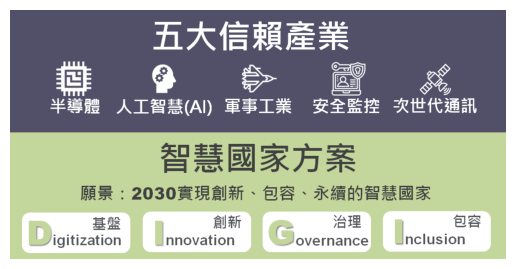

ID: 3
Score: 0.86841947
Content: '## 會議名稱 2024 政府暨教育資訊長高峰會 ## 時間 2024.11.08 - 2024.11.09 ## 簡介 新政府上任後，對於人工智慧（AI）的願景是推動數位轉型，提升政府效能，並促進教育及國防領域的創新應用。此次高峰會的目的是探討最新的AI技術發展、分享實踐案例，並討論如何利用AI提升決策效率與服務品質。通過這次高峰會，凝聚全國政府及教育資訊行政單位各項業務推展之共識，加速各單位在資訊領域、經驗與作法之交流，有助提升全國政府及教育單位資訊業務之執行效益，同時期望能夠達成： 1. 透過AI技術的應用，提升政府及教育機構的運營效率，推動數位化進程。 2. 利用生成式人工智慧（Gen AI）技術，提升政府決策的準確性和效率。 3. 探討最新的資安政策與技術，建立健全的資安防護體系，保障數據與資訊的安全。 4. 分享政府上雲的成功案例，探討臺端技術的應用策略與挑戰。 ### 活動資訊 - **會議地點**：台中林酒店 6F 海洋宴會廳 - **會議地址**：台中市西屯區朝富路 99 號 ### 第一天 (2024/11/08) | 時間 | 內容 | | ------------- | ---------------------------------------- | | 12:30-13:00 | 貴賓報到 | | 13:00-13:10 | 主辦單位致歡迎詞 | | | 中華民國開放系統協會理事長 劉士豪 | | 13:10-13:20 | 貴賓致詞 | | | 台中市市長 盧秀燕 | | 13:20-13:30 | 致歡迎詞 | | | 台灣微軟總經理 卞志祥 | | 13:30-13:35 | 貴賓合影 | | 13:55-14:15 | 貴賓演講 政府在AI人才培育中的策略 | | | 行政院人事行政總處人事長 蘇俊榮 | | 14:35-15:15 | 中場休息與交流 (AI Copilot Demo Booth) | | 15:15-15:55 | **Panel 1** Microsoft Azure OpenAI 與 M365 Copilot 的實際應用 | | | **主講人** | 台灣微軟公共業務事業群總經理 陳守正 | | | **與談人** | 台灣電力公司資訊

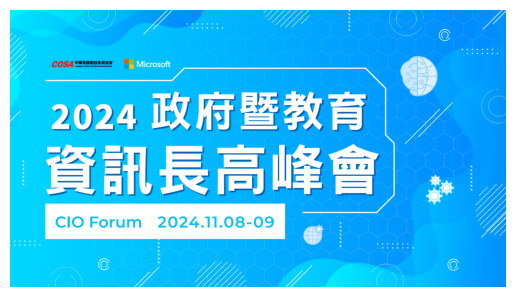

ID: 2
Score: 0.8516386
Content: '### 2024資訊月x臺灣教育科技展 - 智慧國家展區 今年，共有數十家政府單位進行政策成果展示，呈現多元智慧科技應用。單位包含：數位發展部、交通部、經濟部中小及新創企業署、內政部地政司臺灣電子航行圖中心、農業部種苗改良繁殖場、內政部資訊服務司、內政部國家公園署、農業部資訊司等其他單位。 本次資訊月智慧國家展區，不僅展現政府機關在數位轉型上的努力，更提供民眾一個深入了解智慧科技如何改善生活、促進產業發展的機會。透過互動體驗與實例展示，民眾可親身體驗智慧科技帶來的便利與創新。'
Image file: 11.png

image_url:  https://paytonavatarimage.blob.core.windows.net/gov-images/11.png


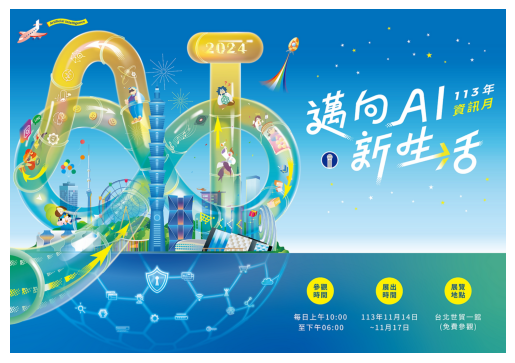

In [22]:
# Test code for using BlobServiceClient
from azure.identity import DefaultAzureCredential
from azure.storage.blob import BlobServiceClient
import matplotlib.pyplot as plt
from io import BytesIO
import requests
from PIL import Image

def display_image_from_blob(image_file):
    # Use public blob storage URL to display image
    image_url = (
        "https://paytonavatarimage.blob.core.windows.net/gov-images/" + image_file
    )
    print("image_url: ", image_url)
    response = requests.get(image_url)
    blob_data = response.content

    img = plt.imread(BytesIO(blob_data))
    plt.imshow(img)
    plt.axis('off')  # No axes for this plot
    plt.show()

def print_results(results):
  print("Results:")
  print(results)
  for result in results:
    print(f"ID: {result['id']}")
    print(f"Score: {result['@search.score']}")
    print(f"Content: {result['content']}")  
    print(f"Image file: {result['product_image_file']}\n")
    display_image_from_blob(result['product_image_file'])

# Pure Vector Search
query = "請問政府在AI人才培育中的策略？"

results = search_client.search(  
    search_text=None,  
    vector=generate_embeddings(query), top_k=3,  
    vector_fields="content_vector",
    select= fields_of_interest
)  
print_results(results)